# Conditional GAN

**Purpose**: This notebook provides a walk through the process of training a Conditional GAN to generate digits on the MNIST dataset. Refer to the paper https://arxiv.org/abs/1411.1784 for a full detailed explanation.

## Package import

In [1]:
import numpy as np
import os
import torch

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from matplotlib.pylab import plt
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from plt_utils import init_figure, plot_current_results

%matplotlib notebook

## Global variable declaration

In [2]:
TRAIN_PARAMETERS = {'batch_size': 64,
                    'num_classes': 10,
                    'img_shape': (1,28,28),
                    'epochs': 200,
                    'learning_rate': 0.0002}

MODEL_HYPERPARAMETERS = {'generator_latent_dim': 100}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data loading

In [3]:
def get_dataloader(batch_size,
                   img_shape):
    
    img_size = img_shape[1:]
    
    dataset = datasets.MNIST(root='./data/MNIST',
                             train=True,
                             download=True,
                             transform=transforms.Compose([transforms.Resize(img_size),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize([0.5], [0.5])]))
    
    return torch.utils.data.DataLoader(dataset,
                                       batch_size=batch_size,
                                       shuffle=True)

In [4]:
dataloader = get_dataloader(TRAIN_PARAMETERS['batch_size'],
                            TRAIN_PARAMETERS['img_shape'])

## Model definition

Generative Adversarial Nets consist on two components competing against each other in a min-max game. These models are:

- **Discriminator:** Estimates the probability of a sample coming from the training data or not.
- **Generator:** Captures the data distribution generating samples accordingly.

Both models play a min max game; the objective of the generator is to fool the discriminator by generating more realistic samples. On the other hand, the discriminator's objective is to identify the samples generated by the generator.

Translating these min max game to mathematics, we adjust the Generator's parameters to minimize $log(1-D(G(z))$ and the Discriminator's parameters to minimize $log(D(x))$. Thus, resulting in the following formula:

![title](imgs/gan_training.png)

The Conditional GAN framework adds to both, the input of the discriminator and the generator, some extra information y (note that the aforementioned formula will need to include the condition on y). This extra information often times is the sample class. The model architecture is depicted in the next figure. As it can be seen in the Figure, the generator concatenatese the sampling from z with the input y. Likewise, the discriminator concatenates x with the input y.

![title](imgs/conditional_gan_architecture.png)

In [5]:
class Generator(nn.Module):
    def __init__(self,
                 n_classes,
                 img_shape,
                 latent_dim):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.img_shape = img_shape
        
        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 256, normalize=False),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [6]:
class Discriminator(nn.Module):
    def __init__(self,
                 n_classes,
                 img_shape):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes,
                                            n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [7]:
def get_generator_model(num_classes,
                        img_shape,
                        latent_dim,
                        lr,
                        device):
    ''' Returns the generator model and its optimizer '''
    
    generator = Generator(num_classes,
                          img_shape,
                          latent_dim)
    
    optimizer = torch.optim.Adam(generator.parameters(),
                                 lr=lr)
    
    return generator.to(device), optimizer

In [8]:
def get_discriminator_model(num_classes,
                            img_shape,
                            lr,
                            device):
    ''' Returns the discriminator model and its optimizer '''
    
    discriminator = Discriminator(num_classes,
                                  img_shape)
    
    optimizer = torch.optim.Adam(discriminator.parameters(),
                                 lr=lr)
    
    return discriminator.to(device), optimizer

In [9]:
generator, optimizer_G = get_generator_model(TRAIN_PARAMETERS['num_classes'],
                                             TRAIN_PARAMETERS['img_shape'],
                                             MODEL_HYPERPARAMETERS['generator_latent_dim'],
                                             TRAIN_PARAMETERS['learning_rate'],
                                             DEVICE)
discriminator, optimizer_D = get_discriminator_model(TRAIN_PARAMETERS['num_classes'],
                                                     TRAIN_PARAMETERS['img_shape'],
                                                     TRAIN_PARAMETERS['learning_rate'],
                                                     DEVICE)

In [10]:
def get_adversarial_loss():
    ''' Returns the adversarial loss '''
    
    return torch.nn.BCEWithLogitsLoss()

In [11]:
adversarial_loss = get_adversarial_loss()

## Model training

In [12]:
def save_reconstruction(generator,
                        generator_latent_dim,
                        n_row,
                        epoch_n,
                        device):
    """Saves a grid of generated digits ranging from 0 to n_classes"""

    # Create the saving directory
    os.makedirs('results', exist_ok=True)
    # Sample noise
    z = torch.FloatTensor(np.random.normal(0, 1, (n_row ** 2, generator_latent_dim))).to(device)
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.LongTensor(labels).to(device)
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "results/%d.png" % epoch_n, nrow=n_row, normalize=True)
    
    return plt.imread("results/%d.png" % epoch_n)

In [13]:
def plot_loss(loss_dict):
    ''' Plots the loss evolution of the discriminator and generator '''
    
    for component_name, component_loss in loss_dict.items():
        
        plt.plot(component_loss, label=component_name)
    
    plt.title('Loss plot')
    plt.legend()
    plt.show()

In [14]:
def train_model(epochs,
                dataloader,
                generator,
                optimizer_G,
                discriminator,
                optimizer_D,
                adv_loss,
                generator_latent_dim,
                n_classes,
                device):
    ''' Trains the GAN model '''
    
    model_loss = {'generator': [], 'discriminator': []}
    
    fig, axs = init_figure()
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        
        running_g_loss = running_d_loss = 0
        
        for x, y in dataloader:
            
            x, y = x.to(device), y.to(device)
            
            batch_size = x.shape[0]
            
            valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
            fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)
        
            
            ## -------------------
            ## Train discriminator
            ## -------------------
            
            optimizer_D.zero_grad()
            
            validity_real = discriminator(x, y)
            d_real_loss = adv_loss(validity_real, valid)
            
            z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, generator_latent_dim))).to(device)
            gen_y = torch.LongTensor(np.random.randint(0, n_classes, batch_size)).to(device)
            gen_x = generator(z, gen_y)
            
            validity_fake = discriminator(gen_x.detach(), gen_y)
            d_fake_loss = adversarial_loss(validity_fake, fake)
            
            d_loss = (d_real_loss + d_fake_loss) / 2
            
            d_loss.backward()
            optimizer_D.step()
            
            ## ---------------
            ## Train generator
            ## ---------------
            
            optimizer_G.zero_grad()
            
            # Sample noise and labels
            z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, generator_latent_dim))).to(device)
            gen_y = torch.LongTensor(np.random.randint(0, n_classes, batch_size)).to(device)
            gen_x = generator(z, gen_y)

            validity = discriminator(gen_x, gen_y)
            g_loss = adv_loss(validity, valid)
            

            g_loss.backward()
            optimizer_G.step()
            
            running_g_loss += g_loss.item()
            
            running_d_loss += d_loss.item()
            
        epoch_g_loss = running_g_loss / len(dataloader)
        epoch_d_loss = running_d_loss / len(dataloader)
        
        print('G Loss: {:.4f} D Loss: {:.4f}'.format(epoch_g_loss,
                                                     epoch_d_loss))
        
        model_loss['generator'].append(epoch_g_loss)
        model_loss['discriminator'].append(epoch_d_loss)
        
        if epoch % 1 == 0:
            generator.eval()

            image = save_reconstruction(generator,
                                generator_latent_dim,
                                n_classes,
                                epoch,
                                device)
            plot_current_results(image, model_loss, fig, axs)
            generator.train()

            

    
    plot_loss(model_loss)

<IPython.core.display.Javascript object>


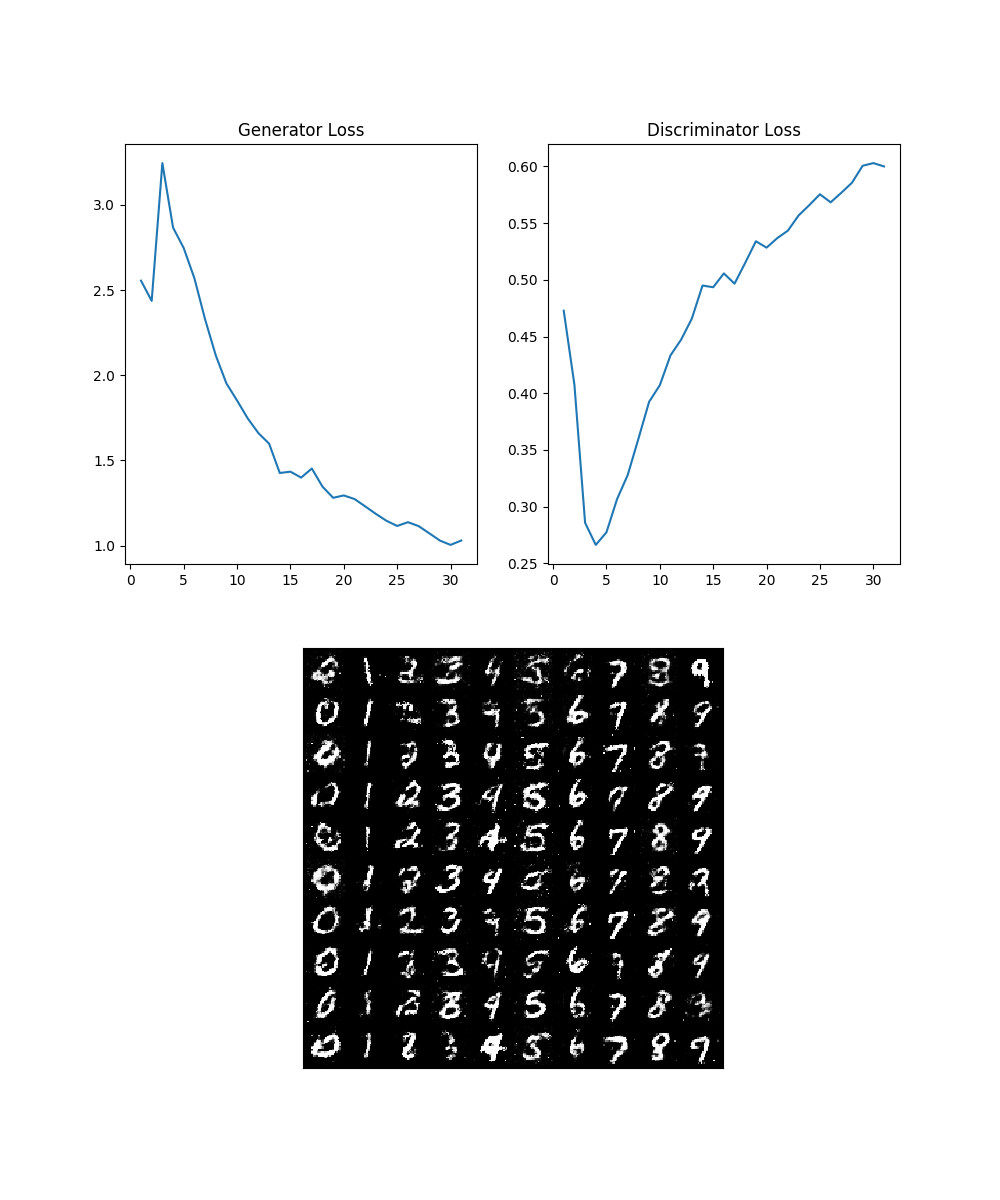

Epoch 0/199
----------
G Loss: 2.5550 D Loss: 0.4727
Epoch 1/199
----------
G Loss: 2.4363 D Loss: 0.4075
Epoch 2/199
----------
G Loss: 3.2450 D Loss: 0.2858
Epoch 3/199
----------
G Loss: 2.8668 D Loss: 0.2663
Epoch 4/199
----------
G Loss: 2.7465 D Loss: 0.2773
Epoch 5/199
----------
G Loss: 2.5695 D Loss: 0.3068
Epoch 6/199
----------
G Loss: 2.3287 D Loss: 0.3281
Epoch 7/199
----------
G Loss: 2.1173 D Loss: 0.3600
Epoch 8/199
----------
G Loss: 1.9522 D Loss: 0.3925
Epoch 9/199
----------
G Loss: 1.8517 D Loss: 0.4071
Epoch 10/199
----------
G Loss: 1.7465 D Loss: 0.4334
Epoch 11/199
----------
G Loss: 1.6603 D Loss: 0.4473
Epoch 12/199
----------
G Loss: 1.5988 D Loss: 0.4658
Epoch 13/199
----------
G Loss: 1.4265 D Loss: 0.4949
Epoch 14/199
----------
G Loss: 1.4342 D Loss: 0.4934
Epoch 15/199
----------
G Loss: 1.3995 D Loss: 0.5056
Epoch 16/199
----------
G Loss: 1.4528 D Loss: 0.4966
Epoch 17/199
----------
G Loss: 1.3465 D Loss: 0.5150
Epoch 18/199
----------
G Loss: 1.2810

In [ ]:
train_model(TRAIN_PARAMETERS['epochs'],
            dataloader,
            generator,
            optimizer_G,
            discriminator,
            optimizer_D,
            adversarial_loss,
            MODEL_HYPERPARAMETERS['generator_latent_dim'],
            TRAIN_PARAMETERS['num_classes'],
            DEVICE)